<a href="https://colab.research.google.com/github/16A0/til/blob/master/Intrinsic_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset

In [0]:
# Check GPU being used. We suggest resetting the environment until you get a P100, otherwise optimization will be slow
!nvidia-smi

Fri Dec  6 07:41:46 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install kornia

In [0]:
#!rm -r neural-painters-pytorch
#!rm -r neural_painters
!git clone https://github.com/reiinakano/neural-painters-pytorch.git
!cp -r neural-painters-pytorch/neural_painters neural_painters

# imports

In [0]:
import torch
import torchvision
import torchvision.utils as utils
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
import moviepy.editor as mpy

from PIL import Image

from neural_painters.vae_painter import VAENeuralPainter
from neural_painters.gan_painter import GANNeuralPainter
from neural_painters.data import FullActionStrokeDataLoader
from neural_painters.canvas import NeuralCanvas, NeuralCanvasStitched
from neural_painters.transforms import RandomRotate, Normalization, RandomCrop, RandomScale
from neural_painters.viz import plot_images, animate_strokes_on_canvas

import kornia

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# all 0 to 1
ACTIONS_TO_IDX = {
    'pressure': 0,
    'size': 1,
    'control_x': 2,
    'control_y': 3,
    'end_x': 4,
    'end_y': 5,
    'color_r': 6,
    'color_g': 7,
    'color_b': 8,
    'start_x': 9,
    'start_y': 10,
    'entry_pressure': 11,
}

inception_v1 = torch.hub.load('pytorch/vision:v0.4.2', 'googlenet', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.4.2


# Choosing parameters

STROKES_PER_BLOCK: 3
REPEAT_CANVAS_HEIGHT 8
REPEAT_CANVAS_WIDTH 14
PAINTER_TYPE: GAN
LAYER: 3B
GRAY_STROKES: False
STOCHASTIC: False
NORMALIZE: True
LEARNING RATE: 0.1
IMAGE NAME: /content/neural-painters-pytorch/images/vanc.jpg
final canvas size H: 288 W: 480	total number of strokes: 336
ORIGINAL IMAGE


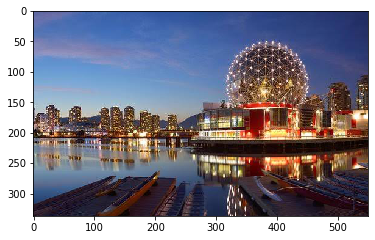

IMAGE DIMENSIONS AFTER PAINTING. If the image looks stretched horizontally or vertically, please adjust REPEAT_CANVAS_HEIGHT and REPEAT_CANVAS_WIDTH


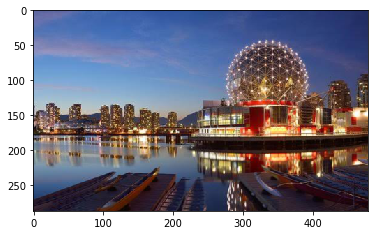

In [0]:
#@title After running this cell manually, it will auto-run if you change the selected value. { run: "auto", display-mode: "form" }

STROKES_PER_BLOCK = 3 #@param {type:"slider", min:1, max:15, step:1}
REPEAT_CANVAS_HEIGHT = 8 #@param {type:"slider", min:1, max:30, step:1}
REPEAT_CANVAS_WIDTH = 14 #@param {type:"slider", min:1, max:30, step:1}
#@markdown REPEAT_CANVAS_HEIGHT and REPEAT_CANVAS_WIDTH are important parameters to choose how many 64x64 canvases make up the height and width of the output image. Try matching them with your target's aspect ratio.
PAINTER_TYPE = "GAN" #@param ["GAN", "VAE"]
#@markdown VAE mode results in more solid strokes that are easier to optimize.
#@markdown GAN mode results in strokes that actually look like paintbrush strokes, although they might be harder to optimize.
LAYER = "3B" #@param ["3A", "3B"]
LAYER_IDX = -12 if LAYER == "3B" else -13
GRAY_STROKES = False #@param {type:"boolean"}
#@markdown Which GoogleNet layer to use for content loss. Deeper layers (3B) result in more abstract results
STOCHASTIC = False #@param {type:"boolean"}
#@markdown Experimental. Adding uncertainty may (or may not) help produce more robust images.
NORMALIZE = True #@param {type:"boolean"}
LEARNING_RATE = 0.1 #@param {type: "number"}
IMAGE_NAME = '/content/neural-painters-pytorch/images/vanc.jpg' #@param {type: "string"}

print('STROKES_PER_BLOCK: {}'.format(STROKES_PER_BLOCK))
print("REPEAT_CANVAS_HEIGHT", REPEAT_CANVAS_HEIGHT)
print("REPEAT_CANVAS_WIDTH", REPEAT_CANVAS_WIDTH)
print('PAINTER_TYPE: {}'.format(PAINTER_TYPE))
print('LAYER: {}'.format(LAYER))
print('GRAY_STROKES: {}'.format(GRAY_STROKES))
print('STOCHASTIC: {}'.format(STOCHASTIC))
print('NORMALIZE: {}'.format(NORMALIZE))
print('LEARNING RATE: {}'.format(LEARNING_RATE))
print('IMAGE NAME: {}'.format(IMAGE_NAME))
_canvas = NeuralCanvasStitched(neural_painter=None, overlap_px=32, 
                               repeat_h=REPEAT_CANVAS_HEIGHT, repeat_w=REPEAT_CANVAS_WIDTH, 
                               strokes_per_block=STROKES_PER_BLOCK)
_image = Image.open(IMAGE_NAME)
print('ORIGINAL IMAGE')
plt.imshow(np.asarray(_image))
plt.show()
print('IMAGE DIMENSIONS AFTER PAINTING. If the image looks stretched horizontally or vertically, please adjust REPEAT_CANVAS_HEIGHT and REPEAT_CANVAS_WIDTH')
_image = transforms.Resize([_canvas.final_canvas_h, 
                           _canvas.final_canvas_w])(_image)
plt.imshow(np.asarray(_image))
plt.show()

# Run optimization

Make sure to stop the optimization when you are happy with the results. Rarely do I need to go above 150 steps.

Downloading...
From: https://drive.google.com/uc?id=1D1TQwnC4aWkWLmWrCbDJf2cXoiEnktl-
To: /root/.cache/neural_painters/checkpoints/gan_neural_painter_latest.tar
11.8MB [00:00, 41.0MB/s]


Downloaded pretrained checkpoint to /root/.cache/neural_painters/checkpoints/gan_neural_painter_latest.tar
Loaded from /root/.cache/neural_painters/checkpoints/gan_neural_painter_latest.tar. Batch 1400000
final canvas size H: 288 W: 480	total number of strokes: 336
Step 0	Cost 28.342798233032227


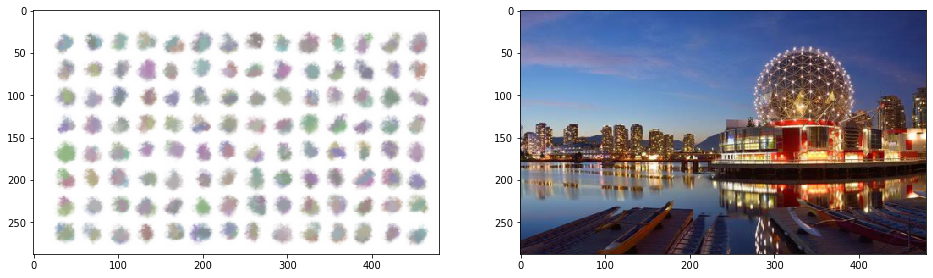

Make sure to stop the optimization when you are happy with the results. In my subjective opinion, the beauty lies in imperfect reconstruction
Step 10	Cost 24.79322052001953


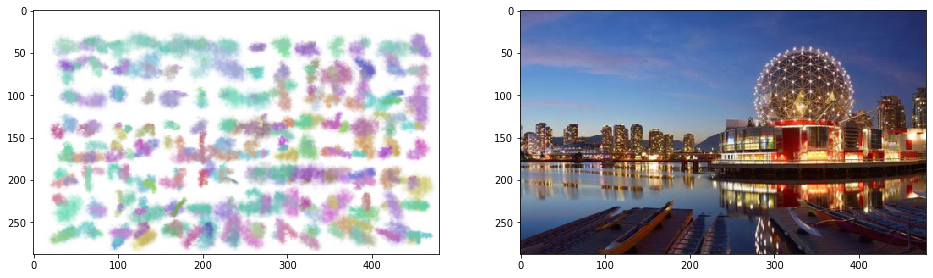

Make sure to stop the optimization when you are happy with the results. In my subjective opinion, the beauty lies in imperfect reconstruction
Step 20	Cost 22.091463088989258


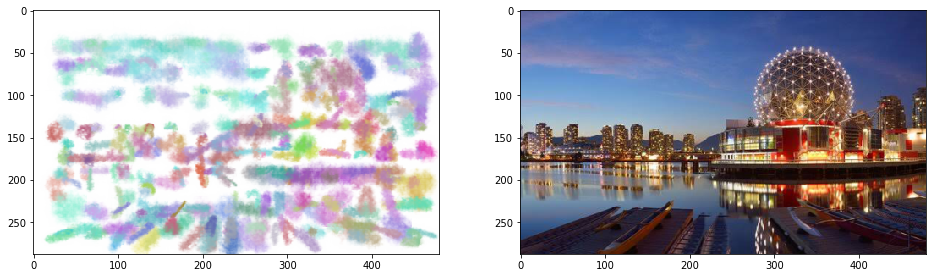

Make sure to stop the optimization when you are happy with the results. In my subjective opinion, the beauty lies in imperfect reconstruction
Step 30	Cost 21.448713302612305


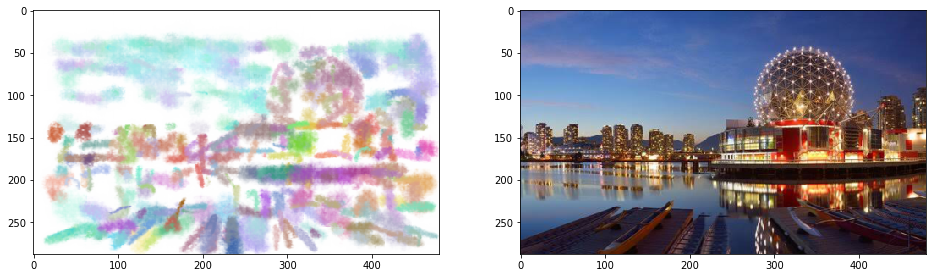

Make sure to stop the optimization when you are happy with the results. In my subjective opinion, the beauty lies in imperfect reconstruction
Step 40	Cost 20.303800582885742


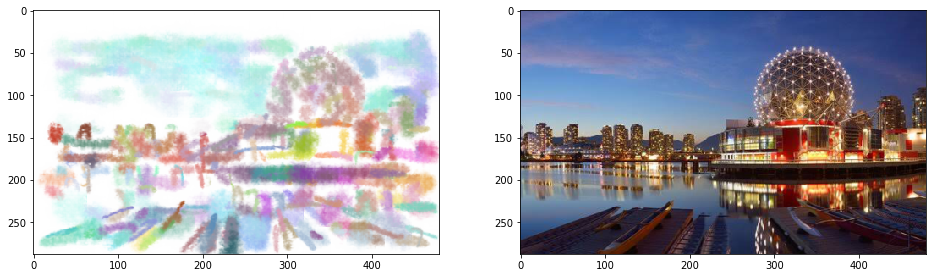

Make sure to stop the optimization when you are happy with the results. In my subjective opinion, the beauty lies in imperfect reconstruction
Step 50	Cost 19.77762222290039


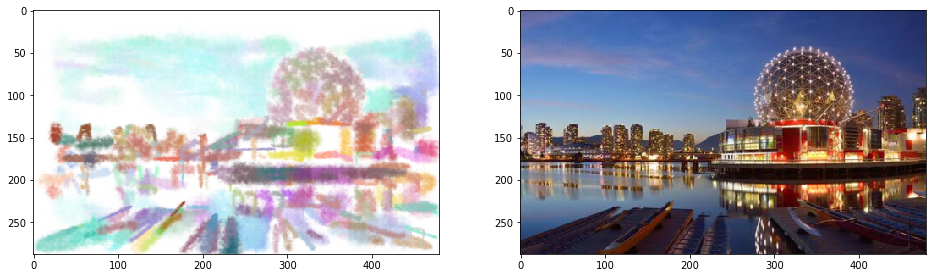

Make sure to stop the optimization when you are happy with the results. In my subjective opinion, the beauty lies in imperfect reconstruction
Step 60	Cost 18.89847755432129


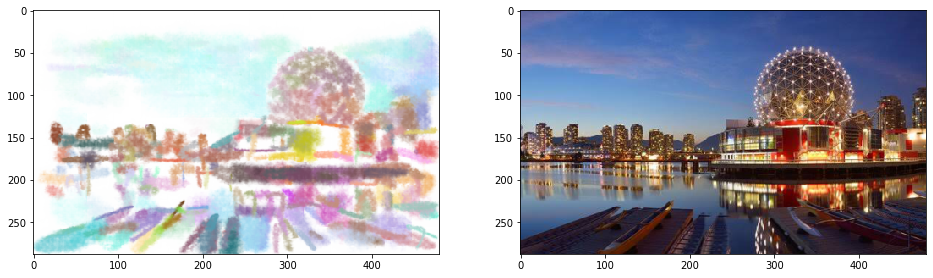

Make sure to stop the optimization when you are happy with the results. In my subjective opinion, the beauty lies in imperfect reconstruction
Step 70	Cost 19.193628311157227


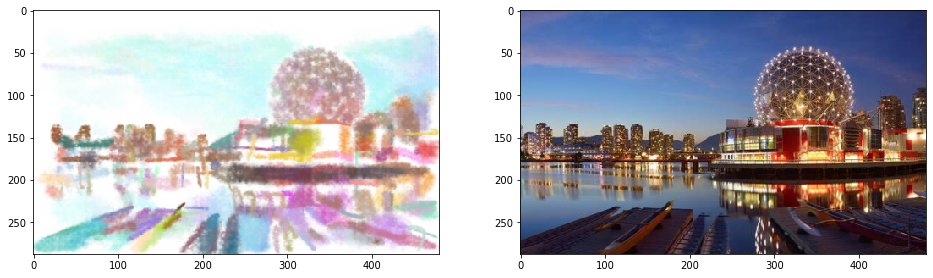

Make sure to stop the optimization when you are happy with the results. In my subjective opinion, the beauty lies in imperfect reconstruction
Step 80	Cost 18.264909744262695


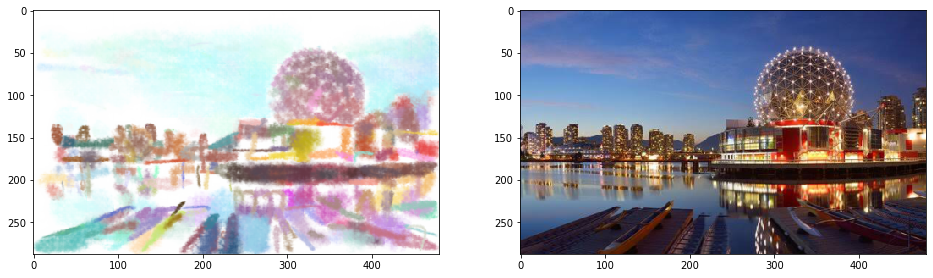

Make sure to stop the optimization when you are happy with the results. In my subjective opinion, the beauty lies in imperfect reconstruction


KeyboardInterrupt: ignored

In [0]:
if PAINTER_TYPE == 'VAE':
  neural_painter = VAENeuralPainter(action_size=len(ACTIONS_TO_IDX), z_size=64, stochastic=STOCHASTIC, 
                                    pretrained=True).to(device).eval()
elif PAINTER_TYPE == 'GAN':
  neural_painter = GANNeuralPainter(action_size=len(ACTIONS_TO_IDX), noise_dim=16, 
                                    num_deterministic=0 if STOCHASTIC else 16, pretrained=True).to(device).eval()
else:
  raise NotImplementedError

# Normalization expected by GoogleNet (images scaled to (-1, 1))
normalizer = Normalization(torch.tensor([0.5, 0.5, 0.5]).to(device), 
                           torch.tensor([0.5, 0.5, 0.5]).to(device))

# Define image augmentations
padder = nn.ConstantPad2d(12, 0.5)
rand_crop_8 = RandomCrop(8)
rand_scale = RandomScale([1 + (i-5)/50. for i in range(11)])
random_rotater = RandomRotate(angle=5, same_throughout_batch=True)
rand_crop_4 = RandomCrop(4)

# Content layer
#feature_extractor = nn.Sequential(*list(vgg19.children())[:6])
feature_extractor = nn.Sequential(*list(inception_v1.children())[:LAYER_IDX])
feature_extractor.eval().to(device)

# Define canvas and action preprocessor
if GRAY_STROKES:
  action_preprocessor = lambda x: (x * torch.tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]]).to(device)).sigmoid()
else:
  action_preprocessor = torch.sigmoid  # torch.sigmoid is the default action preprocessor
canvas = NeuralCanvasStitched(neural_painter=neural_painter, overlap_px=32, 
                              repeat_h=REPEAT_CANVAS_HEIGHT, repeat_w=REPEAT_CANVAS_WIDTH, 
                              strokes_per_block=STROKES_PER_BLOCK, 
                              action_preprocessor=action_preprocessor)

# Load input image
image = Image.open(IMAGE_NAME)
loader = transforms.Compose([
    transforms.Resize([canvas.final_canvas_h, canvas.final_canvas_w]),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor
image = loader(image).unsqueeze(0)[:, :3, :, :].to(device, torch.float)

# Define actions
actions = torch.FloatTensor(canvas.total_num_strokes, 1, len(ACTIONS_TO_IDX)).uniform_().to(device)

optimizer = optim.Adam([actions.requires_grad_()], lr=LEARNING_RATE)

for idx in range(201):
  optimizer.zero_grad()

  # Generate final canvas with all strokes
  output_canvas, _ = canvas(actions)

  # Everything else below is for calculating the loss function for intrinsic style transfer
  
  stacked_canvas = torch.cat([output_canvas, image])

  # Image transformations
  augmented_canvas = rand_crop_4(
      random_rotater(
          rand_crop_8(
              rand_scale(
                  padder(
                      normalizer(stacked_canvas) if NORMALIZE else stacked_canvas)))))

  # Pass through pretrained
  output_features = feature_extractor(augmented_canvas)

  #cost = 100 * torch.pow(output_features[0] - output_features[1], 2).mean()  # L2 loss
  cost = 100 * torch.abs(output_features[0] - output_features[1]).mean()  # L1 loss
  #cost = 100 * torch.abs(stacked_canvas[0] - stacked_canvas[1]).mean()  # pixel loss
  cost.backward()
  optimizer.step()
  if idx % 10 == 0:
    print(f'Step {idx}\tCost {cost.item()}')
    plot_images((stacked_canvas.detach().cpu().numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1), figsize=(16, 16))
    plt.show()
    print('Make sure to stop the optimization when you are happy with the results. In my subjective opinion, the beauty lies in imperfect reconstruction')



# Visualize the results

## Generate a pretty video

In [0]:
_, intermediate_canvases = canvas(actions)

animate_strokes_on_canvas(intermediate_canvases, image, "tmp.mp4", skip_every_n=2)
display(mpy.ipython_display('tmp.mp4', height=400, max_duration=100.))

[MoviePy] >>>> Building video tmp.mp4
[MoviePy] Writing video tmp.mp4


100%|█████████▉| 210/211 [00:01<00:00, 201.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: tmp.mp4 



## Or just display the final canvas

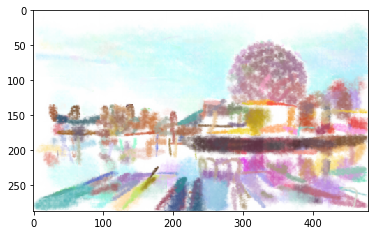

In [0]:
output_canvas, _ = canvas(actions)
plot_images((output_canvas.detach().cpu().numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1), figsize=(6, 6))


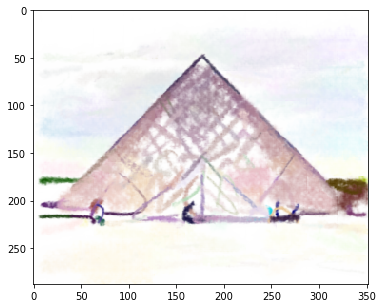

In [0]:
output_canvas, _ = canvas(actions)
plot_images((output_canvas.detach().cpu().numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1), figsize=(6, 6))


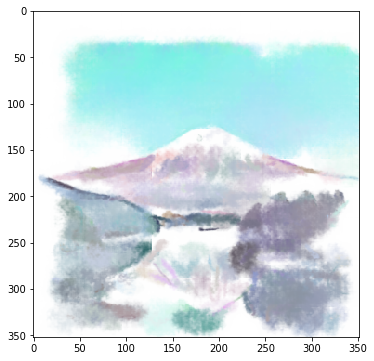

In [0]:
output_canvas, _ = canvas(actions)
plot_images((output_canvas.detach().cpu().numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1), figsize=(6, 6))


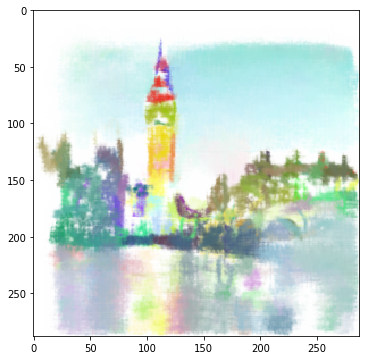

In [0]:
output_canvas, _ = canvas(actions)
plot_images((output_canvas.detach().cpu().numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1), figsize=(6, 6))


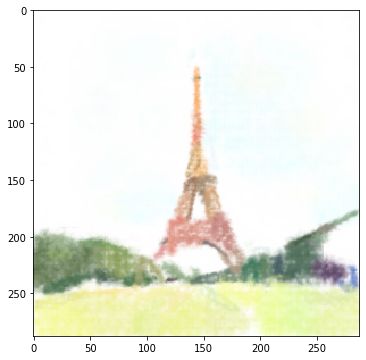

In [0]:
output_canvas, _ = canvas(actions)
plot_images((output_canvas.detach().cpu().numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1), figsize=(6, 6))


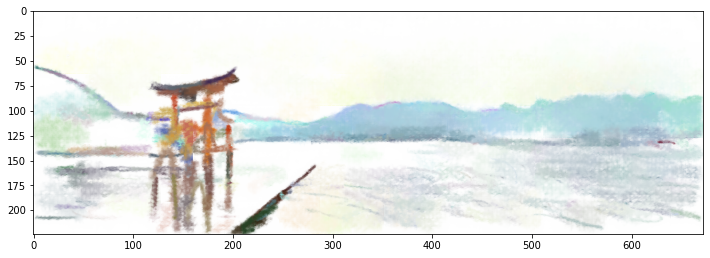

In [0]:
output_canvas, _ = canvas(actions)
plot_images((output_canvas.detach().cpu().numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1), figsize=(12, 12))


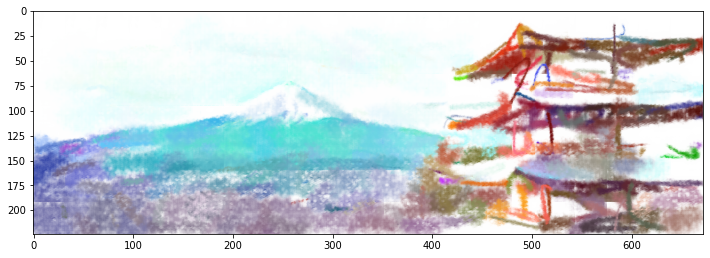

In [0]:
output_canvas, _ = canvas(actions)
plot_images((output_canvas.detach().cpu().numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1), figsize=(12, 12))


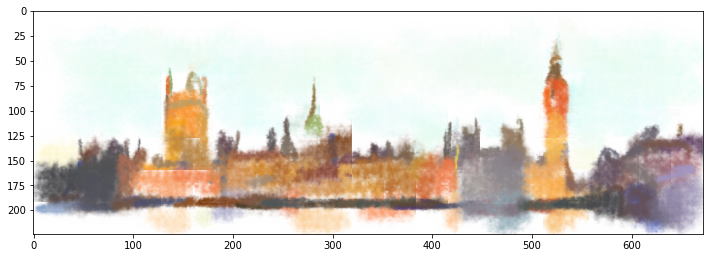

In [0]:
output_canvas, _ = canvas(actions)
plot_images((output_canvas.detach().cpu().numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1), figsize=(12, 12))


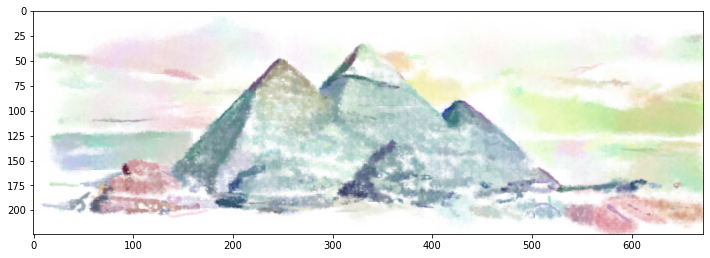

In [0]:
output_canvas, _ = canvas(actions)
plot_images((output_canvas.detach().cpu().numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1), figsize=(12, 12))


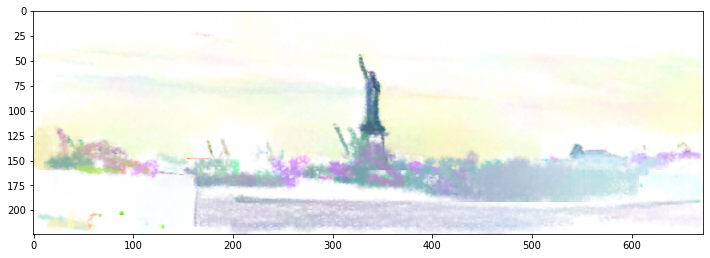

In [0]:
output_canvas, _ = canvas(actions)
plot_images((output_canvas.detach().cpu().numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1), figsize=(12, 12))


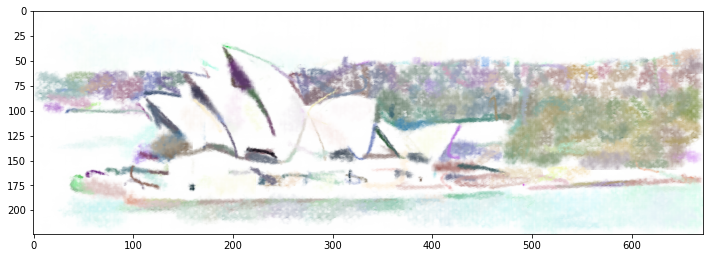

In [0]:
output_canvas, _ = canvas(actions)
plot_images((output_canvas.detach().cpu().numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1), figsize=(12, 12))
